<h2>개인 구글 드라이브와 colab 연동 </h2>

In [1]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


<h2>라이브러리 설치 </h2>

In [3]:
!pip install sklearn-crfsuite
!pip install scikit-learn==0.23.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.8 MB 5.3 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.23.1 which is incompatible.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.1 which is incompatible.


In [38]:
import os
import sklearn_crfsuite
from sklearn_crfsuite import metrics


# 파일 경로
file_path = "/gdrive/My Drive/ml_colab/week6/spacing_data.txt"

# "spacing_data.txt" 파일을 읽고 lines에 읽은 데이터를 저장
with open(file_path, "r", encoding="utf8") as inFile:
    lines = inFile.readlines()

# 데이터를 음절로 이루어진 문장과 정답 값으로 나누어 저장
datas = []

for line in lines:
  pieces = line.strip().split('\t')
  eumjeol_sequence, label = pieces[0].split(), pieces[1].split()
  datas.append((eumjeol_sequence, label))
    
number_of_train_datas = int(len(datas)*0.9)

train_datas = datas[:number_of_train_datas]
test_datas = datas[number_of_train_datas:]
          
print("train_datas 개수 : " + str(len(train_datas)))          
print("test_datas 개수 : " + str(len(test_datas)))

train_datas 개수 : 9000
test_datas 개수 : 1000


In [39]:
"""
과제: 자질 1개 이상 추가하기

우리 말은 조사, 단위, 등의 뒤에서 띄어쓰기를 합니다. 저는 이런 값들이 도움이 되지 않을까 생각하였고, 그것들(모든 값을 포함하지는 않습니다.)을 리스트로 만든 후, 각 음절이 이에 해당하는 지를 자질로 추가하였습니다.

또한, 교수님의 기존 코드는 앞, 뒤 2개의 음절을 참고합니다. 그에 더불어, 하나씩 더 활용을 하는 게 어떨까 하는 생각에 -3_WORD와 +3_WORD를 추가하였습니다."""

criteria = ["은", "는", "을", "를", "게", "께", "써", "로", "개", "분", "병", "잔", "더"]

def sent2feature(eumjeol_sequence):
  features = []
  sequence_length = len(eumjeol_sequence)
  for index, eumjeol in enumerate(eumjeol_sequence):
      feature = { "BOS":False, "EOS":False, "CRITERIA":False, "WORD":eumjeol, "IS_DIGIT":eumjeol.isdigit() }
      if(index == 0):
        feature['BOS'] = True
      elif(index == sequence_length-1):
        feature['EOS'] = True
      
      if eumjeol in criteria:
        feature['CRITERIA'] = True
        

      if(index-1 >= 0):
        feature['-1_WORD'] = eumjeol_sequence[index-1]
      if(index-2 >= 0):
        feature['-2_WORD'] = eumjeol_sequence[index-2]
      if(index-3 >= 0):
        feature['-3_WORD'] = eumjeol_sequence[index-3]
      
      if(index+1 <= sequence_length-1):
        feature['+1_WORD'] = eumjeol_sequence[index+1]
      if(index+2 <= sequence_length-1):
        feature['+2_WORD'] = eumjeol_sequence[index+2]
      if(index-3 >= 0):
        feature['-3_WORD'] = eumjeol_sequence[index-3]
      features.append(feature)

  return features
  
  
train_x, train_y = [], []
for eumjeol_sequence, label in train_datas:
    train_x.append(sent2feature(eumjeol_sequence))
    train_y.append(label)

test_x, test_y = [], []
for eumjeol_sequence, label in test_datas:
    test_x.append(sent2feature(eumjeol_sequence))
    test_y.append(label)

<h2> 1. train_x, train_y를 이용하여 crf 모델 학습 </h2>

In [40]:
#crf = sklearn_crfsuite.CRF(
#        algorithm='lbfgs',
#        c1=0.1,
#        c2=0.1, 
#        max_iterations=100,
#        all_possible_transitions=True
#    )
crf = sklearn_crfsuite.CRF()
crf.fit(train_x, train_y)

CRF(keep_tempfiles=None)

In [41]:
def show_predict_result(test_datas, predict):
  for index_1 in range(len(test_datas)):
      eumjeol_sequence, correct_labels = test_datas[index_1]
      predict_labels = predict[index_1]
     
      correct_sentence, predict_sentence = "", ""
      for index_2 in range(len(eumjeol_sequence)):
          if(index_2 == 0):
              correct_sentence += eumjeol_sequence[index_2]
              predict_sentence += eumjeol_sequence[index_2]
              continue

          if(correct_labels[index_2] == "B"):
              correct_sentence += " "
          correct_sentence += eumjeol_sequence[index_2]

          if (predict_labels[index_2] == "B"):
              predict_sentence += " "
          predict_sentence += eumjeol_sequence[index_2]

      print("정답 문장 : " + correct_sentence)
      print("출력 문장 : " + predict_sentence)
      print()

predict = crf.predict(test_x)
print("Accuracy score : " + str(metrics.flat_accuracy_score(test_y, predict)))
print()

print("10개의 데이터에 대한 모델 출력과 실제 정답 비교")
print()

show_predict_result(test_datas[:10], predict[:10])

Accuracy score : 0.9085166218938885

10개의 데이터에 대한 모델 출력과 실제 정답 비교

정답 문장 : 이에 많은 팬들이 (이름)의 새해 활약과 건강을 기원하며 화답했다.
출력 문장 : 이에 많은 팬들이 (이름)의 새해 활약과 건강을 기원하며 화답했다.

정답 문장 : 그리고 전반 14분 코너킥 상황에서 공격에 가담한 센터백 버질 반 다이크의 헤딩 선제골이 나오며 기선을 제압했다.
출력 문장 : 그리고 전반 14분 코너킥 상황에서 공격에 가담한센터 백버질 반다이 크의 헤딩선 제골이나오며 기선을 제압했다.

정답 문장 : 모든 구단이 시즌 38경기중 25경기를 치른 현 시점에서 토트넘은 승점 4점이 앞선 첼시를 따라잡는 것은 물론, 그 이상도 가능하다.
출력 문장 : 모든 구단이 시즌 38경기 중25경기를 치른 현시점에 서토트넘은 승점 4점이 앞선 첼시를 따라 잡는 것은 물론, 그이 상도 가능하다.

정답 문장 : 전반 5분 만에 본머스의 라이언 프레이저, 전반 12분 칼럼 윌슨에게 연달아 슈팅을 허용하며 불안한 출발을 보였다.
출력 문장 : 전반 5분만에 본머스의라이 언프레이저, 전반12분칼럼 윌슨에게 연달 아슈팅을 허용하며 불안한 출발을 보였다.

정답 문장 : 그러나 갑작스러운 부상으로 결장이 예상돼 아쉬움을 남기게 됐다.
출력 문장 : 그러나 갑작스러운 부상으로 결장이 예상돼 아쉬움을 남기게 됐다.

정답 문장 : 수비수에는 이기제, 민상기(이상 수원), (이름)(대구), (이름)(제주)이 포함됐다.
출력 문장 : 수비수에는 이기제, 민상기(이상 수원), (이름)(대구), (이름)(제주)이 포함됐다.

정답 문장 : 메이슨 대행은 1992년생인 (이름)(29)보다 한 살 많고, 가레스 베일(32), 위고 요리스(35)보다 어리다.
출력 문장 : 메이슨 대행은 1992년생인 (이름)(29) 보다한 살 많고, 가레스베일(32), 위고 요리스(35) 보다어리다.

정답 문장 : 이어 후반 17분에도 시구르드손에게 추가 실점하며 역

자질 추가 전:
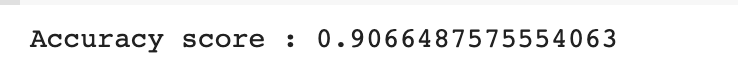


자질 추가 후: 
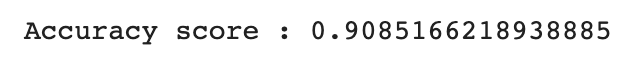